<a href="https://colab.research.google.com/github/brbi1248/CNN_cancer_detection/blob/main/Cancer_Detection_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing Histopathologic Images for Cancer Detection
## Brittany Bilotti

In [ ]:
from google.colab import files

#kaggle.json
uploaded = files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.31G/6.31G [04:46<00:00, 30.1MB/s]
100% 6.31G/6.31G [04:46<00:00, 23.6MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile('/content/histopathologic-cancer-detection.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/histopathologic_dataset')

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import shutil
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import random

## Description of Project
### This dataset contains highly detailed images of lymph node tissues. These images are labeled to indicate the presence (positive samples) or absence (negative samples) of cancer. They exhibit intricate cellular structures, posing challenges for manual analysis. To aid in this, I'll be utilizing a Convolutional Neural Network (CNN), a computer method specialized in studying detailed images. This CNN will analyze the images to spot significant patterns or features indicating the existence of cancer cells. I plan on fine-tuning settings to build a strong system that can accurately find tissue images with cancer cells.

## Description of Data
### Shown below are the histopathologic images that are formatted as TIFF files and standardized to a resolution of 96x96 pixels. The dataset consists of 220,025 images, each the same size and type, making it easy to look at or use for different kinds of analysis. With this image collection is 'train_labels.csv,' containing 220,025 rows to correspond with each image and provides 2 columns: identifiers 'id' and corresponding labels 'label'. The labels indicate whether the image contains tumor tissue or not, with '1' as the presence of tumor tissue and '0' as the absence of tumor tissue.

In [ ]:
#dataset directory
data_dir = '/content/histopathologic_dataset'

#all files in the dataset directory
files_in_dataset = os.listdir(data_dir)

#files and directories in the dataset
for file_or_dir in files_in_dataset:
    print(file_or_dir)

test
train
sample_submission.csv
train_labels.csv


In [ ]:
#contents of train_labels.csv
data_text = pd.read_csv('/content/histopathologic_dataset/train_labels.csv')

#head of train_labels.csv
print("Contents of train_labels.csv:")
print(data_text.head())


Contents of train_labels.csv:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


In [ ]:
#number of rows and columns
num_rows, num_columns = data_text.shape
print(f"Number of rows in the dataset: {num_rows}")
print(f"Number of columns in the dataset: {num_columns}")

Number of rows in the dataset: 220025
Number of columns in the dataset: 2


Image 1 - Dimensions: (96, 96), File Format: TIFF


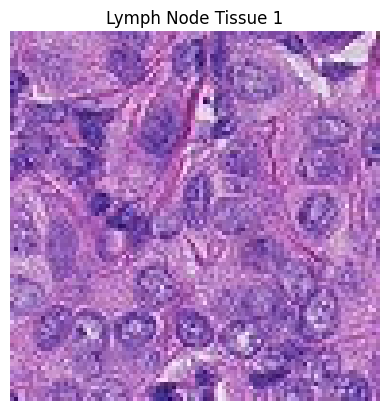

Image 2 - Dimensions: (96, 96), File Format: TIFF


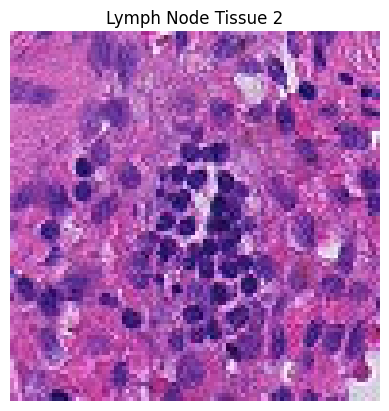

Image 3 - Dimensions: (96, 96), File Format: TIFF


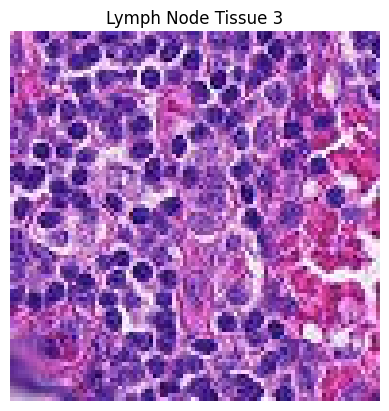

Image 4 - Dimensions: (96, 96), File Format: TIFF


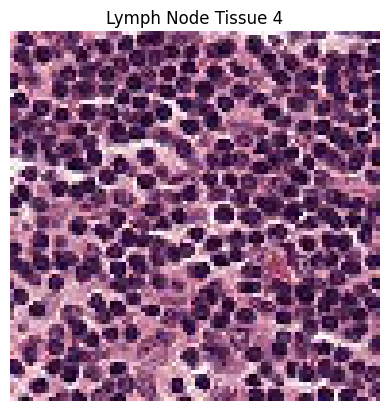

Image 5 - Dimensions: (96, 96), File Format: TIFF


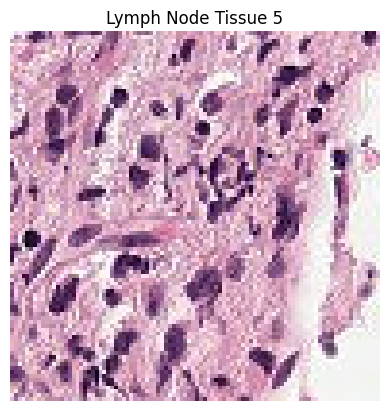


Number of images in the dataset: 220025


In [ ]:
#images in dataset
data_images = '/content/histopathologic_dataset/train'

#all files in the directory
file_list = os.listdir(data_images)

#first 5 images
num_images_to_display = 5

for i in range(num_images_to_display):
    img_path = os.path.join(data_images, file_list[i])
    img = Image.open(img_path)

    #image dimensions and file format
    print(f"Image {i + 1} - Dimensions: {img.size}, File Format: {img.format}")

    #show the image
    plt.imshow(img)
    plt.title(f"Lymph Node Tissue {i + 1}")
    plt.axis('off')
    plt.show()

#number of images in the dataset
num_images = len(file_list)
print(f"\nNumber of images in the dataset: {num_images}")


## Exploratory Data Analysis

### Data Cleaning
### I checked for any repeated or missing information in the dataset and found no duplicate entries or missing data. This ensures for better model accuracy.

In [ ]:

#check for duplicates in id col
duplicate_data = data_text[data_text.duplicated(subset='id', keep=False)]

if not duplicate_data.empty:
    print("Duplicate Data Found:")
    print(duplicate_data)
else:
  print("No Duplicate Data Found")

No Duplicate Data Found


In [ ]:
#check for missing values
missing_data = data_text.isnull().sum()

if missing_data.any():
    print("Missing Data Found:")
    print(missing_data)
else:
  print("No Missing Data")

No Missing Data


### Visualizations
### I created a histogram showing the distribution of tumor classes ('Absence' and 'Presence') and found 130,908 cases without tumors and 89,117 cases with tumors. Additionally, I displayed 20 images for each class, visually highlighting the differences between images with and without tumors.

In [ ]:
#plot absence vs presence of tumor as a historgram
plt.hist(data_text['label'], edgecolor='black', bins=2)
plt.xlabel('Tumor Class')
plt.ylabel('Frequency')
plt.title('Tumor Distribution')
plt.xticks(range(2), ['Absence', 'Presence'])
plt.show()


In [ ]:
#frequencies of each
frequencies = data_text['label'].value_counts()

# Display frequencies
print("Absence of Tumor Frequency:", frequencies[0])
print("Presence of Tumor Frequency:", frequencies[1])

In [ ]:
#get 20 images for each class
class_0_samples = data_text[data_text['label'] == 0].sample(20)
class_1_samples = data_text[data_text['label'] == 1].sample(20)

#plot images
def plot_images(image_samples, label):
    plt.figure(figsize=(15, 8))
    title = "Images of an Absence of a Tumor" if label == 0 else "Images of a Presence of a Tumor"
    plt.suptitle(title, fontsize=16)
    for i, (_, row) in enumerate(image_samples.iterrows(), 1):
        image_path = os.path.join(data_images, row['id'] + '.tif')
        img = Image.open(image_path)
        plt.subplot(4, 5, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Image {i}")
    plt.tight_layout()
    plt.show()

plot_images(class_0_samples, label=0)
plot_images(class_1_samples, label=1)


## Splitting up the data for training
### In order to properly train the CNN model, I had to organize the images into training and validation sets. I opted for an 80-20 split, allocating 80% of the data for training and setting aside 20% for validation purposes to strike a balance between having sufficient data to train the model effectively while ensuring a substantial portion is reserved for validation. The 80-20 split is often considered a good practice in machine learning, as it provides a sizable training set to learn patterns and features within the data while allowing for robust validation to assess the model's performance on unseen examples.

In [ ]:

#check if the 'id' column contains '.tif' extension
if not data_text['id'].str.endswith('.tif').all():
    #add '.tif' extension to the 'id' column
    data_text['id'] = data_text['id'] + '.tif'

    #save the modified DataFrame back to the CSV file
    data_text.to_csv('/content/histopathologic_dataset/train_labels.csv', index=False)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

data_text['label'] = data_text['label'].astype(str)

#imageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #rotation_range=40,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True,
    #fill_mode='nearest',
    validation_split=0.2 # splitting data 80 for training, 20 for validation
)

test_datagen = ImageDataGenerator(rescale=1./255)

data_images = '/content/histopathologic_dataset/train'
valid = '/content/histopathologic_dataset/train'
#load and prepare the images for training using flow_from_dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=data_text,
    directory=data_images,
    x_col='id',
    y_col='label',
    #has_ext=False,
    subset='training',
    target_size=(96, 96),
    batch_size=64,
    class_mode='binary',

    #validate_filenames=False
)

validation_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.20)

#load and prepare the images for validation using flow_from_dataframe
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=data_text,
    directory=data_images,
    x_col='id',
    y_col='label',
    #has_ext=False,
    subset='validation',
    target_size=(96, 96),
    batch_size=64,
    shuffle=False,
    class_mode='binary',
    #validate_filenames=False
)



Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


## Model Architecture and Reasoning
### For this model, I used CNN and started with an intial Conv2D layer to identify basic features like edges and textures, crucial for tumor detection. Then, I added MaxPooling layers that distill and retain key features while minimizing computational load. I added two deeper Conv2D layer, with increased filters to delve into intricate patterns related to tumor tissues.I followed this by flattening the output to prepare for the interpretation of dense layers. The first dense layer has 256 neurons and uses Relu activation to learn higher-level representations while the final dense layer has a single neuron and sigmoid activation to execute binary classification to indicate either the presence of absence of a tumor.A dropout was also added to handle any overfitting.

In [ ]:
#create model
model = Sequential()

#add 2D convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))

#add max-pooling layer
model.add(MaxPooling2D((2, 2)))

#another convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))

#another max-pooling layer
model.add(MaxPooling2D((2, 2)))

#another convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu'))

#another max-pooling layer
model.add(MaxPooling2D((2, 2)))

#flatten output
model.add(Flatten())

#a dd fully connected layers
model.add(Dense(256, activation='relu'))

#handle overfitting
model.add(Dropout(0.3))

#output layer with binary classification
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 128)       0

In [ ]:
#compiling the model with adam and using loss and accuracy to see metrics of each epoch
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
#training the model with 10 epochs
model.fit(train_generator, epochs=10, validation_data=validation_generator)


Epoch 1/10
2751/2751 [==============================] - 416s 146ms/step - loss: 0.4179 - accuracy: 0.8135 - val_loss: 0.3339 - val_accuracy: 0.8611
Epoch 2/10
2751/2751 [==============================] - 344s 125ms/step - loss: 0.3101 - accuracy: 0.8699 - val_loss: 0.2756 - val_accuracy: 0.8897
Epoch 3/10
2751/2751 [==============================] - 352s 128ms/step - loss: 0.2639 - accuracy: 0.8929 - val_loss: 0.2560 - val_accuracy: 0.8976
Epoch 4/10
2751/2751 [==============================] - 342s 124ms/step - loss: 0.2340 - accuracy: 0.9055 - val_loss: 0.2493 - val_accuracy: 0.9020
Epoch 5/10
2751/2751 [==============================] - 380s 138ms/step - loss: 0.2093 - accuracy: 0.9173 - val_loss: 0.2357 - val_accuracy: 0.9076
Epoch 6/10
2751/2751 [==============================] - 344s 125ms/step - loss: 0.1865 - accuracy: 0.9269 - val_loss: 0.2316 - val_accuracy: 0.9084
Epoch 7/10
2751/2751 [==============================] - 364s 132ms/step - loss: 0.1636 - accuracy: 0.9370 - val_

## Results and Analysis
### As we can see from the results displayed below and from training above, the model did remarkably well and achieved an accuracy of approximately 96.34% during training across 10 epochs, while maintaining a solid validation accuracy of 89.84%. Testing the model confirmed its robustness, showcasing an accuracy of 89.84%. Precision and recall metrics ranged from 0.84 to 0.94, showing the model's exceptional ability to distinguish between tumor and non-tumor samples. The confusion matrix further validated this by demonstrating higher precision and recall for both classes. Additionally, the ROC-AUC score of 0.962 showed the model's ability to differentiate between tumor and non-tumor instances.


688/688 [==============================] - 43s 62ms/step
Accuracy: 0.8984206340188615


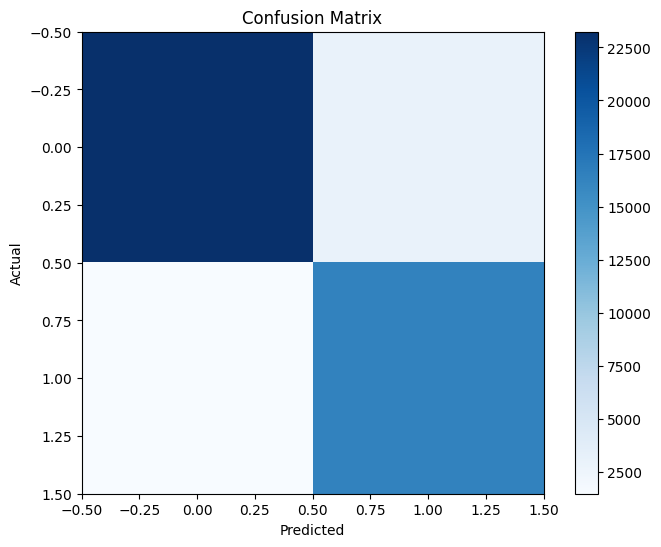

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91     26233
           1       0.84      0.92      0.88     17772

    accuracy                           0.90     44005
   macro avg       0.89      0.90      0.90     44005
weighted avg       0.90      0.90      0.90     44005

[0.33384427428245544, 0.8984206318855286]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#evaluate model
eval = model.evaluate(validation_generator)

#predict probs
pred = model.predict(validation_generator)

#calculate classes based on probabilities
predicted_classes = (pred > 0.5).astype('int32')
true_classes = validation_generator.classes

#accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Accuracy: {accuracy}")

#confusion matrix
conf_matrix = confusion_matrix(validation_generator.classes, predicted_classes)

#classification report
class_report = classification_report(validation_generator.classes, predicted_classes)

#visualize Confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(class_report)
print(eval)

ROC-AUC Score: 0.9627382513562324


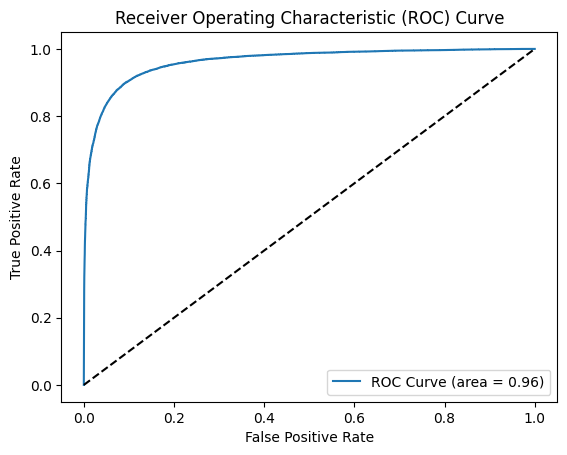

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

#ROC-AUC Score
roc_auc = roc_auc_score(true_classes, pred)
print(f"ROC-AUC Score: {roc_auc}")

#ROC Curve
fpr, tpr, thresholds = roc_curve(true_classes, pred)
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
test_dir = pd.read_csv('/content/histopathologic_dataset/test')
submission_dir = pd.read_csv('/content/histopathologic_dataset/sample_submission.csv')


test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(96, 96),
    batch_size=64,
    class_mode=None,  # Set to None for inference/predictions
    shuffle=False      # Ensure the order of predictions matches the order of files
)

# Make predictions
predictions = model.predict(test_generator)

# Assuming binary classification, extract the predicted labels
predicted_labels = (predictions > 0.5).astype(int)

# If needed, retrieve the filenames or IDs for submission
test_filenames = test_generator.filenames

# Create DataFrame with filenames/IDs and predicted labels
submission_df = pd.DataFrame({
    'id': test_filenames,  # Update this with the relevant column name for IDs
    'label': predicted_labels.flatten()  # Assuming binary classification
})

# Save DataFrame to CSV
submission_df.to_csv('submission.csv', index=False)
submission_df.head()

IsADirectoryError: ignored

In [ ]:
test_df = pd.read_csv('/content/histopathologic_dataset/sample_submission.csv')

from matplotlib.pyplot import imread
# Kaggle testing
from glob import glob
TESTING_BATCH_SIZE = 64
testing_files = glob(os.path.join('/content/histopathologic_dataset/test','*.tif'))
submission = pd.DataFrame()
print(len(testing_files))
for index in range(0, len(testing_files), TESTING_BATCH_SIZE):
    data_frame = pd.DataFrame({'path': testing_files[index:index+TESTING_BATCH_SIZE]})
    data_frame['id'] = data_frame.path.map(lambda x: x.split('/')[3].split(".")[0])
    data_frame['image'] = data_frame['path'].map(imread)
    images = np.stack(data_frame.image, axis=0)
    predicted_labels = [model.predict(np.expand_dims(image/255.0, axis=0))[0][0] for image in images]
    predictions = np.array(predicted_labels)
    data_frame['label'] = predictions
    submission = pd.concat([submission, data_frame[["id", "label"]]])
    if index % 1000 == 0 :
        print(index/len(testing_files) * 100)
submission.to_csv('submission_new_model.csv', index=False, header=True)
print(submission.head())

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 32ms/step
27.84642695534129
1/1 [==============================] - 0s 25ms/step


# Troubleshooting and Hyperparameter Optimization Summary
###In my pursuit of the most accurate model, I began by testing models for just one training round to gauge their starting accuracy efficiently. Initially, I set up a model with a single Conv2D layer using 32 filters and a dense layer with 64 neurons. Soon, I realized that the model needed a specific dense layer with just one neuron and sigmoid activation, or else its accuracy suffered. Tweaking the neurons and filters, I found that using a dense layer with 128 neurons improved accuracy. I tried to add more Conv2D layers, but too many layers increased training time, so I focused on augmenting the filters for the second layer instead. To address overfitting, I included a dropout hyperparameter. My experimentation led to the discovery that having multiple Conv2D layers with increasing filters, a denser layer with more neurons, and a dropout rate significantly improved the model's accuracy.

# Conclusion

### This project aimed to use Convolutional Neural Networks (CNNs) to spot cancer cells in lymph node tissue images. The CNN architecture was meticulously designed and fine-tuned through trial and error. By thoroughly examining and splitting the data, the model showcased strong accuracy, hitting 89.84% on unseen data. It consistently distinguished tumor from non-tumor samples, evident in precision and recall metrics. The model's high ROC-AUC score of 0.962 confirmed its capability in separating tumor instances. Through detailed troubleshooting and parameter adjustments, the model was optimized, showing that refining Conv2D layers, denser layers, and using dropout significantly boosted accuracy. This project illustrates the potential of CNNs in medical image analysis, offering a promising path for accurate cancer detection in medical diagnostics.

In [ ]:
# Make predictions on test data


# Prepare submission file
submission = pd.DataFrame({'ID': test_df['ID'], 'Target': pred.flatten()})
submission.to_csv('submission.csv', index=False)
